# Image Captioning
### (Soumitra Dnyaneshwar Edake)

### Auto Image Caption Generator

Steps:

- Feature Extraction
- Descriptions Generation
- Model Training
- Model Evaluation
- Caption Generator

## Initial Step

In [15]:
#imports
import os
import numpy as np
from numpy import array
from time import time
from pickle import dump
from pickle import load
import string

from keras import Input, Model
from keras.backend import set_value
from keras.layers import Dropout, Embedding, Dense, LSTM, add
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array
from keras_preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

import matplotlib.pyplot as plt
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster


Bad key "text.kerning_factor" on line 4 in
D:\s0um\Softwares\Anaconda3\envs\keras-gpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Define Paths to appropriate directories and files

In [3]:
# input paths
path_dataset = "dataset\\flicker8k-dataset\\Flickr8k_Dataset\\Flicker8k_Dataset\\"
path_tokens = "dataset\\flicker8k-dataset\\Flickr8k_text\\Flickr8k.token.txt"
path_train_set = "dataset\\flicker8k-dataset\\Flickr8k_text\\Flickr_8k.trainImages.txt"
path_test_set = "dataset\\flicker8k-dataset\\Flickr8k_text\\Flickr_8k.testImages.txt"
path_glove_txt = "dataset\\pre-trained-glove\\glove.6B.200d.txt"

# output paths
path_desc = "descriptions.txt"
path_extracted_train_features = "extracted_train_features.enc"
path_extracted_test_features = "extracted_test_features.enc"

Below lines help us to overcome ***keras scrach graph*** error 

In [1]:
import tensorflow as tf
# setting GPU memory growth for no memory glitches
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Feature Extraction

All the features will be extracted from images and will be collectively (train and test) saved in a pickle dumped file.

Define the modified InceptionV3 model

In [7]:
# we need InceptionV3 only to extract features thats why we remove last layer
model = InceptionV3(weights='imagenet')
model_popped = Model(inputs=model.input, outputs=model.layers[-2].output)

In [8]:
# To open sets
def set_opener(path):
    load_set = open(path, 'r')
    data = load_set.readlines()
    load_set.close()
    return data

In [9]:
# pre processing and feature extraction
def feature_extractor(image, in_model):
    img = load_img(image, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    ext_ft = in_model.predict(x)
    ext_ft = np.reshape(ext_ft, ext_ft.shape[1])
    return ext_ft

In [10]:
# get a set of all train images
train_images = set_opener(path_train_set)

In [11]:
# get a set of all test images
test_images = set_opener(path_test_set)

In [89]:
print("Length: Train:", len(train_images))
print("Length: Test: ", len(test_images))

Length: Train: 6000
Length: Test:  1000


In [16]:
all_sets = [train_images, test_images]
outputs = [path_extracted_train_features, path_extracted_test_features]
total_count = 0
# set initial time
start_time = time()

for i, dataset in enumerate(all_sets):
    count = 0
    features_encoded = dict()

    for name in dataset:
        count += 1

        name = name.strip()
        image_path = path_dataset + name

        feature_vector = feature_extractor(image_path, model_popped)

        image_name = name.split('.')[0]
        features_encoded[image_name] = feature_vector

        print('> Processing {}/{}'.format(count, len(dataset)) + ' : %s' % name)

    total_count += count

    # store to file
    dump(features_encoded, open(outputs[i], 'wb'))
    print("\nFeatures extracted :", len(features_encoded))
    print('Features saved to  :', outputs[i], end='\n\n')
        
print("Total Features Extracted :", total_count)
print("Processing Time          :", time() - start_time, "sec")

> Processing 1/6000 : 2513260012_03d33305cf.jpg
> Processing 2/6000 : 2903617548_d3e38d7f88.jpg
> Processing 3/6000 : 3338291921_fe7ae0c8f8.jpg
> Processing 4/6000 : 488416045_1c6d903fe0.jpg
> Processing 5/6000 : 2644326817_8f45080b87.jpg
> Processing 6/6000 : 218342358_1755a9cce1.jpg
> Processing 7/6000 : 2501968935_02f2cd8079.jpg
> Processing 8/6000 : 2699342860_5288e203ea.jpg
> Processing 9/6000 : 2638369467_8fc251595b.jpg
> Processing 10/6000 : 2926786902_815a99a154.jpg
> Processing 11/6000 : 2851304910_b5721199bc.jpg
> Processing 12/6000 : 3423802527_94bd2b23b0.jpg
> Processing 13/6000 : 3356369156_074750c6cc.jpg
> Processing 14/6000 : 2294598473_40637b5c04.jpg
> Processing 15/6000 : 1191338263_a4fa073154.jpg
> Processing 16/6000 : 2380765956_6313d8cae3.jpg
> Processing 17/6000 : 3197891333_b1b0fd1702.jpg
> Processing 18/6000 : 3119887967_271a097464.jpg
> Processing 19/6000 : 2276499757_b44dc6f8ce.jpg
> Processing 20/6000 : 2506892928_7e79bec613.jpg
> Processing 21/6000 : 21872228

> Processing 172/6000 : 2839890871_4b7c7dbd96.jpg
> Processing 173/6000 : 3710468717_c051d96a5f.jpg
> Processing 174/6000 : 3272541970_ac0f1de274.jpg
> Processing 175/6000 : 543363241_74d8246fab.jpg
> Processing 176/6000 : 2661437618_ca7a15f3cb.jpg
> Processing 177/6000 : 2696636252_91ef1491ea.jpg
> Processing 178/6000 : 3092756650_557c5f2d03.jpg
> Processing 179/6000 : 3241965735_8742782a70.jpg
> Processing 180/6000 : 3174417550_d2e6100278.jpg
> Processing 181/6000 : 2712352554_1cafd32812.jpg
> Processing 182/6000 : 3371567346_b6522efdb8.jpg
> Processing 183/6000 : 2102315758_a9148a842f.jpg
> Processing 184/6000 : 3249891130_b241591e89.jpg
> Processing 185/6000 : 488196964_49159f11fd.jpg
> Processing 186/6000 : 2056041678_d6b5b39b26.jpg
> Processing 187/6000 : 2613993276_3c365cca12.jpg
> Processing 188/6000 : 2571096893_694ce79768.jpg
> Processing 189/6000 : 2245618207_fa486ba2b7.jpg
> Processing 190/6000 : 3025513877_1a6160070d.jpg
> Processing 191/6000 : 3638783842_af08dbb518.jpg
> 

> Processing 340/6000 : 2477623312_58e8e8c8af.jpg
> Processing 341/6000 : 3634032601_2236676cdd.jpg
> Processing 342/6000 : 2973272684_4d63cbc241.jpg
> Processing 343/6000 : 2108799322_e25aa6e185.jpg
> Processing 344/6000 : 3628017876_4ac27e687b.jpg
> Processing 345/6000 : 3465396606_5ba1574128.jpg
> Processing 346/6000 : 2789688929_9424fceed1.jpg
> Processing 347/6000 : 3522076584_7c603d2ac5.jpg
> Processing 348/6000 : 3662909101_21b9e59a3e.jpg
> Processing 349/6000 : 1453366750_6e8cf601bf.jpg
> Processing 350/6000 : 2267682214_e1434d853b.jpg
> Processing 351/6000 : 2058472558_7dd5014abd.jpg
> Processing 352/6000 : 3638908276_b1751d30ff.jpg
> Processing 353/6000 : 3016726158_4d15b83b06.jpg
> Processing 354/6000 : 2191453879_11dfe2ba3a.jpg
> Processing 355/6000 : 3441531010_8eebbb507e.jpg
> Processing 356/6000 : 1529044279_4922ead27c.jpg
> Processing 357/6000 : 429174232_ddd4ff5e0b.jpg
> Processing 358/6000 : 3451085951_e66f7f5d5c.jpg
> Processing 359/6000 : 3568505408_4e30def669.jpg
>

> Processing 506/6000 : 3148193539_de9dd48fc8.jpg
> Processing 507/6000 : 544122267_e9e0100bc5.jpg
> Processing 508/6000 : 1798209205_77dbf525b0.jpg
> Processing 509/6000 : 3657503733_9888ccf05e.jpg
> Processing 510/6000 : 871290666_4877e128c0.jpg
> Processing 511/6000 : 2377460540_8cfb62463a.jpg
> Processing 512/6000 : 1499495021_d295ce577c.jpg
> Processing 513/6000 : 1473080948_bae2925dc8.jpg
> Processing 514/6000 : 3765374230_cb1bbee0cb.jpg
> Processing 515/6000 : 3584603849_6cfd9af7dd.jpg
> Processing 516/6000 : 2987576188_f82304f394.jpg
> Processing 517/6000 : 2039457436_fc30f5e1ce.jpg
> Processing 518/6000 : 2040941056_7f5fd50794.jpg
> Processing 519/6000 : 2126950128_74a4882658.jpg
> Processing 520/6000 : 3579842996_3a62ec1bc7.jpg
> Processing 521/6000 : 3240090389_97a8c5d386.jpg
> Processing 522/6000 : 291952021_f111b0fb3d.jpg
> Processing 523/6000 : 3138562460_44227a35cf.jpg
> Processing 524/6000 : 956164675_9ee084364e.jpg
> Processing 525/6000 : 2735979477_eef7c680f9.jpg
> Pr

> Processing 674/6000 : 2447289477_e888df561d.jpg
> Processing 675/6000 : 3047749814_621ed0786b.jpg
> Processing 676/6000 : 2715289538_d77c8d0a85.jpg
> Processing 677/6000 : 2302747917_aa0300eb68.jpg
> Processing 678/6000 : 1252396628_eb81d3905b.jpg
> Processing 679/6000 : 3659090958_a56913ca68.jpg
> Processing 680/6000 : 1445754124_647168f211.jpg
> Processing 681/6000 : 3391924827_53b31542ce.jpg
> Processing 682/6000 : 3088399255_1bd9a6aa04.jpg
> Processing 683/6000 : 3191805046_77c334b506.jpg
> Processing 684/6000 : 3286045254_696c6b15bd.jpg
> Processing 685/6000 : 439492931_a96d590e40.jpg
> Processing 686/6000 : 3126225245_96cd2c053f.jpg
> Processing 687/6000 : 2070831281_dc04b3e15d.jpg
> Processing 688/6000 : 3272847211_9e8a4f8308.jpg
> Processing 689/6000 : 3636126441_5617c89aaa.jpg
> Processing 690/6000 : 408233586_f2c1be3ce1.jpg
> Processing 691/6000 : 58363928_6f7074608c.jpg
> Processing 692/6000 : 3375843443_8d9b242aa5.jpg
> Processing 693/6000 : 241346885_f519ece460.jpg
> Pro

> Processing 845/6000 : 2228167286_7089ab236a.jpg
> Processing 846/6000 : 3251460982_4578a568bb.jpg
> Processing 847/6000 : 495014499_8fd065cfd9.jpg
> Processing 848/6000 : 862054277_34b5a6f401.jpg
> Processing 849/6000 : 3110174991_a4b05f8a46.jpg
> Processing 850/6000 : 2836325261_a3bf5c59be.jpg
> Processing 851/6000 : 2709275718_73fcf08c23.jpg
> Processing 852/6000 : 1153704539_542f7aa3a5.jpg
> Processing 853/6000 : 3697003897_d8ac13be9a.jpg
> Processing 854/6000 : 359082432_c1fd5aa2d6.jpg
> Processing 855/6000 : 442918418_0f29c97fa9.jpg
> Processing 856/6000 : 455611732_d65bf3e976.jpg
> Processing 857/6000 : 2760715910_87c7bdeb87.jpg
> Processing 858/6000 : 3595216998_0a19efebd0.jpg
> Processing 859/6000 : 520491467_54cbc0a866.jpg
> Processing 860/6000 : 2109479807_eec8d72ca7.jpg
> Processing 861/6000 : 3249597269_935e0a375a.jpg
> Processing 862/6000 : 1859726819_9a793b3b44.jpg
> Processing 863/6000 : 230016181_0c52b95304.jpg
> Processing 864/6000 : 534200447_b0f3ff02be.jpg
> Proces

> Processing 1011/6000 : 1597319381_1e80d9e39c.jpg
> Processing 1012/6000 : 405331006_4e94e07698.jpg
> Processing 1013/6000 : 3493000349_81c540e828.jpg
> Processing 1014/6000 : 505955292_026f1489f2.jpg
> Processing 1015/6000 : 3122497129_d08f5729b8.jpg
> Processing 1016/6000 : 3428386573_670f5362f0.jpg
> Processing 1017/6000 : 2269961438_cae7a9c725.jpg
> Processing 1018/6000 : 3156113206_53c2a7b5d8.jpg
> Processing 1019/6000 : 3725177385_62d5e13634.jpg
> Processing 1020/6000 : 3590654365_fd4819f48b.jpg
> Processing 1021/6000 : 3178371973_60c6b8f110.jpg
> Processing 1022/6000 : 1402641725_5e027ecaa7.jpg
> Processing 1023/6000 : 1449625950_fc9a8d02d9.jpg
> Processing 1024/6000 : 2836808985_b26e4ca09e.jpg
> Processing 1025/6000 : 506412121_67ecc7ec05.jpg
> Processing 1026/6000 : 944788251_a0bcd4b960.jpg
> Processing 1027/6000 : 2714878018_1593c38d69.jpg
> Processing 1028/6000 : 3050606344_af711c726c.jpg
> Processing 1029/6000 : 2488795251_c108c77b13.jpg
> Processing 1030/6000 : 2613920405

> Processing 1176/6000 : 2925242998_9e0db9b4a2.jpg
> Processing 1177/6000 : 557721978_dfde31bc02.jpg
> Processing 1178/6000 : 3085973779_29f44fbdaa.jpg
> Processing 1179/6000 : 696663662_232edd58af.jpg
> Processing 1180/6000 : 3025315215_a5d367971a.jpg
> Processing 1181/6000 : 278002947_3fd22a2cb6.jpg
> Processing 1182/6000 : 3492734013_e6b177ed99.jpg
> Processing 1183/6000 : 3621647714_fc67ab2617.jpg
> Processing 1184/6000 : 2838125339_3dd314e315.jpg
> Processing 1185/6000 : 3432495898_a5859f06b6.jpg
> Processing 1186/6000 : 278002875_d011ae9dc5.jpg
> Processing 1187/6000 : 3248352729_ab264b2222.jpg
> Processing 1188/6000 : 861608773_bdafd5c996.jpg
> Processing 1189/6000 : 3325129757_7a1979ac11.jpg
> Processing 1190/6000 : 1895768965_43cd9d164f.jpg
> Processing 1191/6000 : 3381038951_225bb163af.jpg
> Processing 1192/6000 : 3120266797_47e7d91614.jpg
> Processing 1193/6000 : 3194134352_bc1b2a25d7.jpg
> Processing 1194/6000 : 2878578240_caf64c3b19.jpg
> Processing 1195/6000 : 3298199743_

> Processing 1342/6000 : 3489774350_a94e6c7bfc.jpg
> Processing 1343/6000 : 2929669711_b2d5a640f0.jpg
> Processing 1344/6000 : 2918653119_f535fc25c4.jpg
> Processing 1345/6000 : 244443352_d7636e1253.jpg
> Processing 1346/6000 : 3116731299_6139b25c18.jpg
> Processing 1347/6000 : 1580172290_e19067e0dd.jpg
> Processing 1348/6000 : 3614595423_f9e0ab4fb0.jpg
> Processing 1349/6000 : 2805873509_4f68afc4b4.jpg
> Processing 1350/6000 : 241347496_1a35fec8dc.jpg
> Processing 1351/6000 : 2790909995_8b7a03d9d1.jpg
> Processing 1352/6000 : 3350260112_fcb47ff6b2.jpg
> Processing 1353/6000 : 3377570617_d2f2225a74.jpg
> Processing 1354/6000 : 2256218522_53b92bcbb2.jpg
> Processing 1355/6000 : 3373870185_f79163fa51.jpg
> Processing 1356/6000 : 258476074_f28f4a1ae6.jpg
> Processing 1357/6000 : 3386893620_5f0bb4e794.jpg
> Processing 1358/6000 : 143237785_93f81b3201.jpg
> Processing 1359/6000 : 2960033435_c20cc7399a.jpg
> Processing 1360/6000 : 2851198725_37b6027625.jpg
> Processing 1361/6000 : 2414384480

> Processing 1508/6000 : 2584020755_14e2b3e8fc.jpg
> Processing 1509/6000 : 3475552729_a3abd81ee6.jpg
> Processing 1510/6000 : 1799271536_6e69c8f1dc.jpg
> Processing 1511/6000 : 3726700898_c50494b8bd.jpg
> Processing 1512/6000 : 2868324804_5cc8030484.jpg
> Processing 1513/6000 : 3264464625_c711cc40c6.jpg
> Processing 1514/6000 : 2929272606_2a5923b38e.jpg
> Processing 1515/6000 : 539744890_85e63f5854.jpg
> Processing 1516/6000 : 3459419203_cd7c68ce4d.jpg
> Processing 1517/6000 : 518610439_b64ab21c02.jpg
> Processing 1518/6000 : 2165459064_5b81ff23eb.jpg
> Processing 1519/6000 : 2271667421_7b21fc23b8.jpg
> Processing 1520/6000 : 241345596_91e0e2daf5.jpg
> Processing 1521/6000 : 3685373706_37f2ced9ff.jpg
> Processing 1522/6000 : 2746839158_4195210d27.jpg
> Processing 1523/6000 : 816084977_21c1811c9a.jpg
> Processing 1524/6000 : 3154886184_ac842655b6.jpg
> Processing 1525/6000 : 1474474514_b3eb492722.jpg
> Processing 1526/6000 : 1388346434_524d0b6dfa.jpg
> Processing 1527/6000 : 447722389_

> Processing 1672/6000 : 3551787566_b5ebbe2440.jpg
> Processing 1673/6000 : 3564742915_5f940b95b4.jpg
> Processing 1674/6000 : 2672354635_3a03f76486.jpg
> Processing 1675/6000 : 3155361712_2cbf59c78e.jpg
> Processing 1676/6000 : 2121357310_f8235311da.jpg
> Processing 1677/6000 : 3259694057_fae7484b0a.jpg
> Processing 1678/6000 : 2172526745_649f420569.jpg
> Processing 1679/6000 : 110595925_f3395c8bd6.jpg
> Processing 1680/6000 : 3692746368_ab7d97ab31.jpg
> Processing 1681/6000 : 493507605_48fe8e3739.jpg
> Processing 1682/6000 : 3270273940_61ef506f05.jpg
> Processing 1683/6000 : 3379839396_0cd84b55f1.jpg
> Processing 1684/6000 : 3509611207_7645b1d28d.jpg
> Processing 1685/6000 : 2424976964_98f58a0618.jpg
> Processing 1686/6000 : 551403320_dfdcf9fc3b.jpg
> Processing 1687/6000 : 233242340_09963100a3.jpg
> Processing 1688/6000 : 3015898903_70bebb8903.jpg
> Processing 1689/6000 : 1235685934_be89b231fb.jpg
> Processing 1690/6000 : 3254640083_eb34b8edfe.jpg
> Processing 1691/6000 : 3457315666

> Processing 1836/6000 : 2480820830_bdec1f5b76.jpg
> Processing 1837/6000 : 1523800748_a59e980eee.jpg
> Processing 1838/6000 : 3453019315_cfd5c10dae.jpg
> Processing 1839/6000 : 3273163189_dece7babf4.jpg
> Processing 1840/6000 : 3241487502_f4f0cc4a8a.jpg
> Processing 1841/6000 : 111537217_082a4ba060.jpg
> Processing 1842/6000 : 3559993787_c49644dcc5.jpg
> Processing 1843/6000 : 961189263_0990f3bcb5.jpg
> Processing 1844/6000 : 2877511986_c965ced502.jpg
> Processing 1845/6000 : 3028095878_07341efc9c.jpg
> Processing 1846/6000 : 3220200084_3ea129336e.jpg
> Processing 1847/6000 : 2823075967_be4c350e9e.jpg
> Processing 1848/6000 : 407569668_19b3f8eaf6.jpg
> Processing 1849/6000 : 859620561_de417cac1e.jpg
> Processing 1850/6000 : 421932359_edbf181f44.jpg
> Processing 1851/6000 : 640409060_6af18fdd54.jpg
> Processing 1852/6000 : 3074617663_2f2634081d.jpg
> Processing 1853/6000 : 1285067106_2adc307240.jpg
> Processing 1854/6000 : 2382411771_a16145f345.jpg
> Processing 1855/6000 : 146577646_9e

> Processing 2000/6000 : 3419238351_ac18b440c0.jpg
> Processing 2001/6000 : 3445296377_1e5082b44b.jpg
> Processing 2002/6000 : 3462165890_c13ce13eff.jpg
> Processing 2003/6000 : 2451114871_8617ae2f16.jpg
> Processing 2004/6000 : 3621652774_fd9634bd5b.jpg
> Processing 2005/6000 : 3647170476_0fd71a4c9f.jpg
> Processing 2006/6000 : 3594822096_e1144b85d6.jpg
> Processing 2007/6000 : 799199774_142b1c3bb2.jpg
> Processing 2008/6000 : 444047125_66b249287c.jpg
> Processing 2009/6000 : 2552949275_b8cdc450cc.jpg
> Processing 2010/6000 : 3147913471_322ea231d9.jpg
> Processing 2011/6000 : 2528521798_fb689eba8d.jpg
> Processing 2012/6000 : 3637013_c675de7705.jpg
> Processing 2013/6000 : 3217056901_fe2c70377d.jpg
> Processing 2014/6000 : 3649307685_60c1294d2a.jpg
> Processing 2015/6000 : 447800028_0242008fa3.jpg
> Processing 2016/6000 : 502671104_b2114246c7.jpg
> Processing 2017/6000 : 3309042087_ee96d94b8a.jpg
> Processing 2018/6000 : 3537806062_c50d814aba.jpg
> Processing 2019/6000 : 2695085448_a1

> Processing 2168/6000 : 3704431444_f337ec2b90.jpg
> Processing 2169/6000 : 270809922_043e3bef06.jpg
> Processing 2170/6000 : 2343879696_59a82f496f.jpg
> Processing 2171/6000 : 469617651_278e586e46.jpg
> Processing 2172/6000 : 3185662156_c877583c53.jpg
> Processing 2173/6000 : 3195969533_98f5de0fab.jpg
> Processing 2174/6000 : 248174959_2522871152.jpg
> Processing 2175/6000 : 3016741474_72b4355198.jpg
> Processing 2176/6000 : 2469351714_d72becd21e.jpg
> Processing 2177/6000 : 3431101934_99a6c55914.jpg
> Processing 2178/6000 : 171488318_fb26af58e2.jpg
> Processing 2179/6000 : 3632197966_0c5061025f.jpg
> Processing 2180/6000 : 3518334317_bc40bae18d.jpg
> Processing 2181/6000 : 3535056297_e16f014cb7.jpg
> Processing 2182/6000 : 2055646179_169807fed4.jpg
> Processing 2183/6000 : 2226587791_66e29dd01d.jpg
> Processing 2184/6000 : 242109387_e497277e07.jpg
> Processing 2185/6000 : 639865690_d66d480879.jpg
> Processing 2186/6000 : 3376942201_2c45d99237.jpg
> Processing 2187/6000 : 3080891382_e

> Processing 2330/6000 : 824782868_a8f532f3a6.jpg
> Processing 2331/6000 : 320093980_5388cb3733.jpg
> Processing 2332/6000 : 3658016590_f761e72dc3.jpg
> Processing 2333/6000 : 365128300_6966058139.jpg
> Processing 2334/6000 : 3587092143_c63030ed6d.jpg
> Processing 2335/6000 : 3540241710_a4f49cde52.jpg
> Processing 2336/6000 : 1552065993_b4dcd2eadf.jpg
> Processing 2337/6000 : 407678652_1f475acd65.jpg
> Processing 2338/6000 : 1428578577_82864facae.jpg
> Processing 2339/6000 : 2394922193_310166d6af.jpg
> Processing 2340/6000 : 390992388_d74daee638.jpg
> Processing 2341/6000 : 3417037373_67f7db2dd2.jpg
> Processing 2342/6000 : 766061382_6c7ff514c4.jpg
> Processing 2343/6000 : 2924870944_90ff9eca1a.jpg
> Processing 2344/6000 : 3259222980_04fb62df97.jpg
> Processing 2345/6000 : 482047956_9a29e9cee6.jpg
> Processing 2346/6000 : 2618866067_07cbc83dc5.jpg
> Processing 2347/6000 : 2140747429_62cfd89ae9.jpg
> Processing 2348/6000 : 504765160_b4b083b293.jpg
> Processing 2349/6000 : 2162469360_ff7

> Processing 2494/6000 : 3092200805_dd1f83ddbe.jpg
> Processing 2495/6000 : 428796930_476a3d6395.jpg
> Processing 2496/6000 : 2694426634_118566f7ab.jpg
> Processing 2497/6000 : 3759230208_1c2a492b12.jpg
> Processing 2498/6000 : 3560891822_7d4c1e3580.jpg
> Processing 2499/6000 : 443885436_6e927e6c58.jpg
> Processing 2500/6000 : 2606433181_f8f9d38579.jpg
> Processing 2501/6000 : 3286017638_c688c83e3d.jpg
> Processing 2502/6000 : 2873648844_8efc7d78f1.jpg
> Processing 2503/6000 : 3451344589_6787bd06ef.jpg
> Processing 2504/6000 : 57417274_d55d34e93e.jpg
> Processing 2505/6000 : 760138567_762d9022d4.jpg
> Processing 2506/6000 : 3380072636_4cd59385fd.jpg
> Processing 2507/6000 : 516998046_1175674fcd.jpg
> Processing 2508/6000 : 1517807181_ca6588f2a0.jpg
> Processing 2509/6000 : 2249865945_f432c8e5da.jpg
> Processing 2510/6000 : 2381583688_a6dd0a7279.jpg
> Processing 2511/6000 : 3498354674_b636c7992f.jpg
> Processing 2512/6000 : 2652155912_8ba5426790.jpg
> Processing 2513/6000 : 2500354186_0

> Processing 2658/6000 : 2847514745_9a35493023.jpg
> Processing 2659/6000 : 3595412126_4020d4643b.jpg
> Processing 2660/6000 : 2151300603_248a9fe715.jpg
> Processing 2661/6000 : 2841449931_84a05850ec.jpg
> Processing 2662/6000 : 3152317129_177b4678b7.jpg
> Processing 2663/6000 : 3019609769_c7809177f6.jpg
> Processing 2664/6000 : 3197247245_9c93b60b8a.jpg
> Processing 2665/6000 : 3084011664_76d37c6559.jpg
> Processing 2666/6000 : 938162709_21443d352f.jpg
> Processing 2667/6000 : 3397633339_d1ae6d9a0e.jpg
> Processing 2668/6000 : 2807209904_389d81f33a.jpg
> Processing 2669/6000 : 1659396176_ced00a549f.jpg
> Processing 2670/6000 : 972381743_5677b420ab.jpg
> Processing 2671/6000 : 388386075_9ac3a89ada.jpg
> Processing 2672/6000 : 523692399_d2e261a302.jpg
> Processing 2673/6000 : 3281611946_f42deed2e1.jpg
> Processing 2674/6000 : 3516299821_8f0375d221.jpg
> Processing 2675/6000 : 489773343_a8aecf7db3.jpg
> Processing 2676/6000 : 332045444_583acaefc3.jpg
> Processing 2677/6000 : 2524003134_5

> Processing 2821/6000 : 2676649969_482caed129.jpg
> Processing 2822/6000 : 708945669_08e7ffb9a7.jpg
> Processing 2823/6000 : 3561639055_5ac66ae92f.jpg
> Processing 2824/6000 : 3474958471_9106beb07f.jpg
> Processing 2825/6000 : 2369840118_a1c4240ab7.jpg
> Processing 2826/6000 : 3138504165_c7ae396294.jpg
> Processing 2827/6000 : 3534046564_4f8546e364.jpg
> Processing 2828/6000 : 613030608_4355e007c7.jpg
> Processing 2829/6000 : 330849796_c575c3108a.jpg
> Processing 2830/6000 : 2828583747_8cfb7217af.jpg
> Processing 2831/6000 : 2089442007_6fc798548c.jpg
> Processing 2832/6000 : 536721406_884ab8fece.jpg
> Processing 2833/6000 : 3308488725_f91d9aba27.jpg
> Processing 2834/6000 : 108898978_7713be88fc.jpg
> Processing 2835/6000 : 691770760_48ce80a674.jpg
> Processing 2836/6000 : 3227111573_c82f7d68b1.jpg
> Processing 2837/6000 : 3484625231_5b1a1a07b8.jpg
> Processing 2838/6000 : 639120223_7db6bdb61f.jpg
> Processing 2839/6000 : 3497106366_d1a256e723.jpg
> Processing 2840/6000 : 3484365373_98

> Processing 2986/6000 : 1028205764_7e8df9a2ea.jpg
> Processing 2987/6000 : 3341477531_4e37450f35.jpg
> Processing 2988/6000 : 3429581486_4556471d1a.jpg
> Processing 2989/6000 : 2602866141_be9928408d.jpg
> Processing 2990/6000 : 185972340_781d60ccfd.jpg
> Processing 2991/6000 : 3279228339_71deaa3d9b.jpg
> Processing 2992/6000 : 2266061169_dfbf8f0595.jpg
> Processing 2993/6000 : 3527184455_1a9c074ff2.jpg
> Processing 2994/6000 : 469029994_349e138606.jpg
> Processing 2995/6000 : 3326086533_23a0a54a8e.jpg
> Processing 2996/6000 : 2396100671_3a9d67f03d.jpg
> Processing 2997/6000 : 697582336_601462e052.jpg
> Processing 2998/6000 : 3717309680_e5105afa6d.jpg
> Processing 2999/6000 : 2988244398_5da7012fce.jpg
> Processing 3000/6000 : 3205754736_32c29b5208.jpg
> Processing 3001/6000 : 483841513_e660391880.jpg
> Processing 3002/6000 : 377872672_d499aae449.jpg
> Processing 3003/6000 : 2817847072_5eb3bc30ac.jpg
> Processing 3004/6000 : 2306186887_0bd8ed3792.jpg
> Processing 3005/6000 : 2517082705_

> Processing 3153/6000 : 3377344932_6dfce93248.jpg
> Processing 3154/6000 : 3259757648_71edb4347b.jpg
> Processing 3155/6000 : 3289817083_4e78e1c05a.jpg
> Processing 3156/6000 : 3277162496_dff7eeb59e.jpg
> Processing 3157/6000 : 3046286572_d2050ab0d9.jpg
> Processing 3158/6000 : 1434607942_da5432c28c.jpg
> Processing 3159/6000 : 3146630574_05d9ebbed1.jpg
> Processing 3160/6000 : 2295447147_458cfea65a.jpg
> Processing 3161/6000 : 3268175963_113d90d178.jpg
> Processing 3162/6000 : 404890608_33f138aefa.jpg
> Processing 3163/6000 : 2257798999_d9d1b9a45a.jpg
> Processing 3164/6000 : 3439982121_0afc6d5973.jpg
> Processing 3165/6000 : 390360326_26f5936189.jpg
> Processing 3166/6000 : 1464120327_d90279ca3a.jpg
> Processing 3167/6000 : 2899501488_90d5da5474.jpg
> Processing 3168/6000 : 2763601657_09a52a063f.jpg
> Processing 3169/6000 : 3271468462_701eb88d3b.jpg
> Processing 3170/6000 : 418357172_bdddf71d32.jpg
> Processing 3171/6000 : 300274198_eefd8e057e.jpg
> Processing 3172/6000 : 2814406547

> Processing 3316/6000 : 2252299132_14ca6e584b.jpg
> Processing 3317/6000 : 2328616978_fb21be2b87.jpg
> Processing 3318/6000 : 308956341_642589e9cc.jpg
> Processing 3319/6000 : 3016759846_062663f8ab.jpg
> Processing 3320/6000 : 1262454669_f1caafec2d.jpg
> Processing 3321/6000 : 3111897772_5211a37a02.jpg
> Processing 3322/6000 : 3126981064_1e803c3d7f.jpg
> Processing 3323/6000 : 445655284_c29e6d7323.jpg
> Processing 3324/6000 : 2684489465_32ba1d0344.jpg
> Processing 3325/6000 : 257588281_39e1c9d929.jpg
> Processing 3326/6000 : 3394750987_a32ecc477e.jpg
> Processing 3327/6000 : 3143991972_7193381aeb.jpg
> Processing 3328/6000 : 2272823323_3b7291cd47.jpg
> Processing 3329/6000 : 374176648_ba4b88c221.jpg
> Processing 3330/6000 : 2561341745_2d77d3ff7d.jpg
> Processing 3331/6000 : 3417231408_6ce951c011.jpg
> Processing 3332/6000 : 2679851489_a58780291e.jpg
> Processing 3333/6000 : 2268601066_b018b124fd.jpg
> Processing 3334/6000 : 2884092603_786b53a74b.jpg
> Processing 3335/6000 : 937559727_

> Processing 3480/6000 : 3036596725_541bbe0955.jpg
> Processing 3481/6000 : 325576658_59f68bdbd6.jpg
> Processing 3482/6000 : 2924908529_0ecb3cdbaa.jpg
> Processing 3483/6000 : 3258394043_a0b6a94dce.jpg
> Processing 3484/6000 : 3415165462_e1cb536d08.jpg
> Processing 3485/6000 : 3472703856_568d9778b5.jpg
> Processing 3486/6000 : 3523920786_0eb63993fd.jpg
> Processing 3487/6000 : 1357689954_72588dfdc4.jpg
> Processing 3488/6000 : 3219065971_702c4e8c34.jpg
> Processing 3489/6000 : 3266399073_40820596d5.jpg
> Processing 3490/6000 : 485738889_c2a00876a6.jpg
> Processing 3491/6000 : 883040210_3c4a10f030.jpg
> Processing 3492/6000 : 1448511770_1a4a9c453b.jpg
> Processing 3493/6000 : 3339751521_7a8768be27.jpg
> Processing 3494/6000 : 3467282545_273a97b628.jpg
> Processing 3495/6000 : 2282043629_91b7831352.jpg
> Processing 3496/6000 : 2561751298_320eef38ec.jpg
> Processing 3497/6000 : 2656987333_80dcc82c05.jpg
> Processing 3498/6000 : 2562483332_eb791a3ce5.jpg
> Processing 3499/6000 : 331899558

> Processing 3646/6000 : 3227594168_3351722aae.jpg
> Processing 3647/6000 : 2467803152_70eeca1334.jpg
> Processing 3648/6000 : 556568556_bc5124dc8e.jpg
> Processing 3649/6000 : 3096918227_f9d26a7db2.jpg
> Processing 3650/6000 : 181415975_2627aa6668.jpg
> Processing 3651/6000 : 3407584080_c6abf71ae3.jpg
> Processing 3652/6000 : 3425071001_e7c9809ef2.jpg
> Processing 3653/6000 : 490044494_d2d546be8d.jpg
> Processing 3654/6000 : 3271061953_700b96520c.jpg
> Processing 3655/6000 : 431018958_84b2beebff.jpg
> Processing 3656/6000 : 3041348852_872c027c16.jpg
> Processing 3657/6000 : 934375844_dd149fed18.jpg
> Processing 3658/6000 : 2532294586_4cd76a837d.jpg
> Processing 3659/6000 : 2417623030_afdc1024b5.jpg
> Processing 3660/6000 : 3443853670_6c79fcfcb2.jpg
> Processing 3661/6000 : 3739833689_a0038545bd.jpg
> Processing 3662/6000 : 2082005167_a0d6a70020.jpg
> Processing 3663/6000 : 2665904080_8a3b9639d5.jpg
> Processing 3664/6000 : 121971540_0a986ee176.jpg
> Processing 3665/6000 : 1262077938_8

> Processing 3810/6000 : 3671851846_60c25269df.jpg
> Processing 3811/6000 : 1338523142_57fce8229b.jpg
> Processing 3812/6000 : 3331102049_bc65cf6198.jpg
> Processing 3813/6000 : 346253487_687150ab04.jpg
> Processing 3814/6000 : 3404408360_430f73b034.jpg
> Processing 3815/6000 : 2479180530_7ebba2d8bf.jpg
> Processing 3816/6000 : 1248953128_24c9f8d924.jpg
> Processing 3817/6000 : 109823394_83fcb735e1.jpg
> Processing 3818/6000 : 2355819665_39021ff642.jpg
> Processing 3819/6000 : 2490863987_715383944a.jpg
> Processing 3820/6000 : 839295615_bb9baf2f95.jpg
> Processing 3821/6000 : 390992102_67fa31b22f.jpg
> Processing 3822/6000 : 1539166395_0cdc0accee.jpg
> Processing 3823/6000 : 215876547_fa584c5ec3.jpg
> Processing 3824/6000 : 1398613231_18de248606.jpg
> Processing 3825/6000 : 3335097235_538f4777c3.jpg
> Processing 3826/6000 : 2255338013_566127590b.jpg
> Processing 3827/6000 : 2619267133_53a5904ef4.jpg
> Processing 3828/6000 : 3150252702_828a570d46.jpg
> Processing 3829/6000 : 3085357792_

> Processing 3978/6000 : 2892989340_bb7e0e5548.jpg
> Processing 3979/6000 : 2109911919_af45b93ef3.jpg
> Processing 3980/6000 : 269898095_d00ac7d7a4.jpg
> Processing 3981/6000 : 3341489212_a879e1544a.jpg
> Processing 3982/6000 : 3162289423_4ca8915d0c.jpg
> Processing 3983/6000 : 488089932_c3a5fa4140.jpg
> Processing 3984/6000 : 2133650765_fc6e5f295e.jpg
> Processing 3985/6000 : 3528105511_12ff45dc9c.jpg
> Processing 3986/6000 : 3544669026_1b5c0e6316.jpg
> Processing 3987/6000 : 609681901_66809d2dc1.jpg
> Processing 3988/6000 : 3207775692_bb897d9afd.jpg
> Processing 3989/6000 : 575636303_b0b8fd4eee.jpg
> Processing 3990/6000 : 3643684616_9d2be87a5a.jpg
> Processing 3991/6000 : 2769731772_18c44c18e2.jpg
> Processing 3992/6000 : 3399843227_3b9d2a8dbf.jpg
> Processing 3993/6000 : 3506869953_802f463178.jpg
> Processing 3994/6000 : 2089555297_95cf001fa7.jpg
> Processing 3995/6000 : 2896668718_0c3cff910f.jpg
> Processing 3996/6000 : 3501083764_cf592292a6.jpg
> Processing 3997/6000 : 3081330705

> Processing 4141/6000 : 109671650_f7bbc297fa.jpg
> Processing 4142/6000 : 314685044_da4390728e.jpg
> Processing 4143/6000 : 532131603_c82d454c8a.jpg
> Processing 4144/6000 : 337647771_3b819feaba.jpg
> Processing 4145/6000 : 489134459_1b3f46fc03.jpg
> Processing 4146/6000 : 3437315443_ba2263f92e.jpg
> Processing 4147/6000 : 512550372_438849ce19.jpg
> Processing 4148/6000 : 2978024878_a45b282bf4.jpg
> Processing 4149/6000 : 2217728745_92b6779016.jpg
> Processing 4150/6000 : 3364796213_b8948913b5.jpg
> Processing 4151/6000 : 3556390715_65c6d1e88b.jpg
> Processing 4152/6000 : 2278776373_fe499a93be.jpg
> Processing 4153/6000 : 2244551043_21b8cca866.jpg
> Processing 4154/6000 : 3646453252_5ebbbaa6cc.jpg
> Processing 4155/6000 : 3473320907_3884a7203b.jpg
> Processing 4156/6000 : 513269597_c38308feaf.jpg
> Processing 4157/6000 : 399679638_d3036da331.jpg
> Processing 4158/6000 : 2045023435_181854c013.jpg
> Processing 4159/6000 : 2255342813_5b2ac6d633.jpg
> Processing 4160/6000 : 508261758_78fb

> Processing 4304/6000 : 2555622234_3e531e4014.jpg
> Processing 4305/6000 : 2512682478_b67cc525c7.jpg
> Processing 4306/6000 : 58368365_03ed3e5bdf.jpg
> Processing 4307/6000 : 2741380826_cfe0ddf0a9.jpg
> Processing 4308/6000 : 2514581496_8f4102377e.jpg
> Processing 4309/6000 : 2986671935_0c60bbb3fa.jpg
> Processing 4310/6000 : 3618908551_7fd2de5710.jpg
> Processing 4311/6000 : 241347243_c751557497.jpg
> Processing 4312/6000 : 272940778_a184dbea42.jpg
> Processing 4313/6000 : 373219198_149af371d9.jpg
> Processing 4314/6000 : 2102724238_3cf921d7bb.jpg
> Processing 4315/6000 : 2792212974_23b1ef05fa.jpg
> Processing 4316/6000 : 2816259113_461f8dedb0.jpg
> Processing 4317/6000 : 526955751_f519d62b58.jpg
> Processing 4318/6000 : 3527715826_ea5b4e8de4.jpg
> Processing 4319/6000 : 832128857_1390386ea6.jpg
> Processing 4320/6000 : 1298866571_b4c496b71c.jpg
> Processing 4321/6000 : 3291255271_a185eba408.jpg
> Processing 4322/6000 : 478208896_90e7187b64.jpg
> Processing 4323/6000 : 3613242966_a1c

> Processing 4468/6000 : 315021440_122d56ebd7.jpg
> Processing 4469/6000 : 3544233095_4bca71df1d.jpg
> Processing 4470/6000 : 2521983429_33218366bd.jpg
> Processing 4471/6000 : 1620397000_3883e3ecd3.jpg
> Processing 4472/6000 : 3078844565_16e9cdcea2.jpg
> Processing 4473/6000 : 1508269285_6c5723f67d.jpg
> Processing 4474/6000 : 792362827_5ab5281b99.jpg
> Processing 4475/6000 : 2240539658_dea8db6e55.jpg
> Processing 4476/6000 : 3728164558_52729baefa.jpg
> Processing 4477/6000 : 3460458114_35037d4d4c.jpg
> Processing 4478/6000 : 2934022873_3fdd69aee4.jpg
> Processing 4479/6000 : 3178599352_c57fdebcd2.jpg
> Processing 4480/6000 : 3656151153_b4ed5d94c4.jpg
> Processing 4481/6000 : 2394003437_184a838aa9.jpg
> Processing 4482/6000 : 957230475_48f4285ffe.jpg
> Processing 4483/6000 : 3601803640_5f3cb05acf.jpg
> Processing 4484/6000 : 2751567262_e089b33ed9.jpg
> Processing 4485/6000 : 3620492762_7f6a9b4746.jpg
> Processing 4486/6000 : 2255332561_3375897ff0.jpg
> Processing 4487/6000 : 322249696

> Processing 4793/6000 : 3183195653_11b66acb34.jpg
> Processing 4794/6000 : 2612608861_92beaa3d0b.jpg
> Processing 4795/6000 : 905355838_3a43fdfd4e.jpg
> Processing 4796/6000 : 3594029059_cee1f4c59a.jpg
> Processing 4797/6000 : 3604314527_5077cd9d43.jpg
> Processing 4798/6000 : 2319175397_3e586cfaf8.jpg
> Processing 4799/6000 : 3648988742_888a16f600.jpg
> Processing 4800/6000 : 365759754_6cf7068c9a.jpg
> Processing 4801/6000 : 2865409854_afedf98860.jpg
> Processing 4802/6000 : 2568417021_afa68423e5.jpg
> Processing 4803/6000 : 3681651647_08eba60f89.jpg
> Processing 4804/6000 : 3346711367_5e7b29e20f.jpg
> Processing 4805/6000 : 3309082580_7228067ee0.jpg
> Processing 4806/6000 : 2552723989_7bc93e0f7b.jpg
> Processing 4807/6000 : 3273403495_fcd09c453e.jpg
> Processing 4808/6000 : 3677954655_df4c0845aa.jpg
> Processing 4809/6000 : 3220140234_e072856e6c.jpg
> Processing 4810/6000 : 3130093622_362f32f2bb.jpg
> Processing 4811/6000 : 2084103826_ffd76b1e3e.jpg
> Processing 4812/6000 : 35181186

> Processing 4959/6000 : 2083778090_3aecaa11cc.jpg
> Processing 4960/6000 : 2747436384_9470c56cb9.jpg
> Processing 4961/6000 : 2752175795_c9def67895.jpg
> Processing 4962/6000 : 3532539748_795d16ef07.jpg
> Processing 4963/6000 : 3661239105_973f8216c4.jpg
> Processing 4964/6000 : 3676561090_9828a9f6d0.jpg
> Processing 4965/6000 : 300539993_eede2d6695.jpg
> Processing 4966/6000 : 1184967930_9e29ce380d.jpg
> Processing 4967/6000 : 2857558098_98e9249284.jpg
> Processing 4968/6000 : 501520507_c86f805ab8.jpg
> Processing 4969/6000 : 2863848437_f2592ab42d.jpg
> Processing 4970/6000 : 3372251830_baa3665928.jpg
> Processing 4971/6000 : 394136487_4fc531b33a.jpg
> Processing 4972/6000 : 262681159_e5fed3acf0.jpg
> Processing 4973/6000 : 3349258288_5300c40430.jpg
> Processing 4974/6000 : 3421129418_088af794f7.jpg
> Processing 4975/6000 : 3269895626_7b253c82ed.jpg
> Processing 4976/6000 : 3326204251_2f9e446a2f.jpg
> Processing 4977/6000 : 3474176841_cde2bee67c.jpg
> Processing 4978/6000 : 2004674713

> Processing 5123/6000 : 1405221276_21634dcd58.jpg
> Processing 5124/6000 : 3687996569_99163a41c3.jpg
> Processing 5125/6000 : 578644583_da3ff18dd1.jpg
> Processing 5126/6000 : 3546474710_903c3c9fd3.jpg
> Processing 5127/6000 : 1670592963_39731a3dac.jpg
> Processing 5128/6000 : 3017220118_6a9212dfdb.jpg
> Processing 5129/6000 : 485741580_ab523fa657.jpg
> Processing 5130/6000 : 2831215155_07ba8f1805.jpg
> Processing 5131/6000 : 3359089834_263e529c71.jpg
> Processing 5132/6000 : 365584746_681f33fa46.jpg
> Processing 5133/6000 : 241345533_99c731403a.jpg
> Processing 5134/6000 : 3250589803_3f440ba781.jpg
> Processing 5135/6000 : 2178306830_6af49375b4.jpg
> Processing 5136/6000 : 2636876892_9353521a1c.jpg
> Processing 5137/6000 : 774009278_8e75b7d498.jpg
> Processing 5138/6000 : 3362871440_6c0f27c480.jpg
> Processing 5139/6000 : 3021780428_497542a072.jpg
> Processing 5140/6000 : 2949497756_be8e58e6bd.jpg
> Processing 5141/6000 : 3649916507_b88a3d2082.jpg
> Processing 5142/6000 : 2079110798_

> Processing 5290/6000 : 133905560_9d012b47f3.jpg
> Processing 5291/6000 : 3586239953_da4fb3f775.jpg
> Processing 5292/6000 : 269361490_a22ae818bf.jpg
> Processing 5293/6000 : 2289096282_4ef120f189.jpg
> Processing 5294/6000 : 3643684044_a131168127.jpg
> Processing 5295/6000 : 2251992614_0c601fae2c.jpg
> Processing 5296/6000 : 1810651611_35aae644fb.jpg
> Processing 5297/6000 : 3474999131_788cbf253f.jpg
> Processing 5298/6000 : 1550772959_9ca9fa625f.jpg
> Processing 5299/6000 : 2709683703_5385ea9ef4.jpg
> Processing 5300/6000 : 3623331945_df0f51d7dd.jpg
> Processing 5301/6000 : 3274879561_74997bbfff.jpg
> Processing 5302/6000 : 3426933951_2302a941d8.jpg
> Processing 5303/6000 : 3432656291_a6c7981f6e.jpg
> Processing 5304/6000 : 468871328_72990babd4.jpg
> Processing 5305/6000 : 2426303900_0a8d52eb14.jpg
> Processing 5306/6000 : 451597318_4f370b1339.jpg
> Processing 5307/6000 : 3402638444_dab914a3de.jpg
> Processing 5308/6000 : 3485599424_94de8ede51.jpg
> Processing 5309/6000 : 3357937209

> Processing 5454/6000 : 3432730942_4dc4685277.jpg
> Processing 5455/6000 : 2698487246_e827404cac.jpg
> Processing 5456/6000 : 3547704737_57d42d5d9d.jpg
> Processing 5457/6000 : 3724738804_f00748a137.jpg
> Processing 5458/6000 : 3307077951_dd31f1971c.jpg
> Processing 5459/6000 : 1924234308_c9ddcf206d.jpg
> Processing 5460/6000 : 3088677667_4a8befb70e.jpg
> Processing 5461/6000 : 2271890493_da441718ba.jpg
> Processing 5462/6000 : 3627679667_0e3de9fc90.jpg
> Processing 5463/6000 : 539676201_c8f1f04952.jpg
> Processing 5464/6000 : 265223843_9ef21e1872.jpg
> Processing 5465/6000 : 2158247955_484f0a1f11.jpg
> Processing 5466/6000 : 3672057606_cb6393dbd9.jpg
> Processing 5467/6000 : 2992658871_ac786d37a6.jpg
> Processing 5468/6000 : 3381788544_2c50e139dd.jpg
> Processing 5469/6000 : 69189650_6687da7280.jpg
> Processing 5470/6000 : 3347701468_bb0001b035.jpg
> Processing 5471/6000 : 1342780478_bacc32344d.jpg
> Processing 5472/6000 : 3473534758_1ae3847781.jpg
> Processing 5473/6000 : 3159569570

> Processing 5618/6000 : 403678611_73978faed7.jpg
> Processing 5619/6000 : 3339586622_a7676b30e1.jpg
> Processing 5620/6000 : 2448793019_5881c025f9.jpg
> Processing 5621/6000 : 3515358125_9e1d796244.jpg
> Processing 5622/6000 : 280932151_ae14a67be5.jpg
> Processing 5623/6000 : 195084264_72fb347b0f.jpg
> Processing 5624/6000 : 2619454551_c4bb726a85.jpg
> Processing 5625/6000 : 2635483351_bc1a8273aa.jpg
> Processing 5626/6000 : 3329858093_0ec73f2190.jpg
> Processing 5627/6000 : 3455898176_f0e003ce58.jpg
> Processing 5628/6000 : 2726301121_95a2fbd22b.jpg
> Processing 5629/6000 : 2256320794_0286c31bfa.jpg
> Processing 5630/6000 : 2224995194_518859d97d.jpg
> Processing 5631/6000 : 3678100844_e3a9802471.jpg
> Processing 5632/6000 : 284279868_2ca98e3dcd.jpg
> Processing 5633/6000 : 3422979565_e08cd77bfe.jpg
> Processing 5634/6000 : 3609999845_faf5d2fe74.jpg
> Processing 5635/6000 : 3187364311_4c2a87083b.jpg
> Processing 5636/6000 : 3082474922_9c3533eaf6.jpg
> Processing 5637/6000 : 873633312_

> Processing 5784/6000 : 1303335399_b3facd47ab.jpg
> Processing 5785/6000 : 1287931016_fb015e2e10.jpg
> Processing 5786/6000 : 269630255_c3ec75c792.jpg
> Processing 5787/6000 : 2797438951_88a3ed7541.jpg
> Processing 5788/6000 : 2144846312_d4c738dc6c.jpg
> Processing 5789/6000 : 2473737724_355599a263.jpg
> Processing 5790/6000 : 2301379282_5fbcf230d1.jpg
> Processing 5791/6000 : 2933643390_1c6086684b.jpg
> Processing 5792/6000 : 3323952123_deb50b0629.jpg
> Processing 5793/6000 : 78984436_ad96eaa802.jpg
> Processing 5794/6000 : 1468429623_f001988691.jpg
> Processing 5795/6000 : 2696951725_e0ae54f6da.jpg
> Processing 5796/6000 : 3551170666_01df31412d.jpg
> Processing 5797/6000 : 2956895529_ec6275060e.jpg
> Processing 5798/6000 : 1263801010_5c74bf1715.jpg
> Processing 5799/6000 : 433855742_c2a6fda763.jpg
> Processing 5800/6000 : 3134644844_493eec6cdc.jpg
> Processing 5801/6000 : 3441399292_60c83bd5db.jpg
> Processing 5802/6000 : 3467510271_0f57e52768.jpg
> Processing 5803/6000 : 2447035752

> Processing 5946/6000 : 2472678549_67068a1566.jpg
> Processing 5947/6000 : 263233914_d25004e4cd.jpg
> Processing 5948/6000 : 435054077_3506dbfcf4.jpg
> Processing 5949/6000 : 2930580341_d36eec8e3c.jpg
> Processing 5950/6000 : 3640329164_20cb245fd5.jpg
> Processing 5951/6000 : 3062273350_fd66106f21.jpg
> Processing 5952/6000 : 2578003921_e23b78e85f.jpg
> Processing 5953/6000 : 3493255026_5fdaa52cbe.jpg
> Processing 5954/6000 : 287999021_998c2eeb91.jpg
> Processing 5955/6000 : 3134385454_4f1d55333f.jpg
> Processing 5956/6000 : 2684323357_c7a6d05d05.jpg
> Processing 5957/6000 : 3164328039_2c56acf594.jpg
> Processing 5958/6000 : 2951750234_a4741f708b.jpg
> Processing 5959/6000 : 3726076549_0efb38854b.jpg
> Processing 5960/6000 : 2312731013_1a3a8e25c6.jpg
> Processing 5961/6000 : 1808007704_ee8a93abb4.jpg
> Processing 5962/6000 : 2764732789_1392e962d0.jpg
> Processing 5963/6000 : 2325386353_1f1a05e1ce.jpg
> Processing 5964/6000 : 3014986976_0e7b858970.jpg
> Processing 5965/6000 : 207642854

> Processing 116/1000 : 3537400880_8f410d747d.jpg
> Processing 117/1000 : 2419221084_01a14176b4.jpg
> Processing 118/1000 : 172097782_f0844ec317.jpg
> Processing 119/1000 : 244571201_0339d8e8d1.jpg
> Processing 120/1000 : 3467219837_7d62213dec.jpg
> Processing 121/1000 : 2928152792_b16c73434a.jpg
> Processing 122/1000 : 401079494_562454c4d6.jpg
> Processing 123/1000 : 2396691909_6b8c2f7c44.jpg
> Processing 124/1000 : 3243588540_b418ac7eda.jpg
> Processing 125/1000 : 3592992234_6d3fe58a70.jpg
> Processing 126/1000 : 1417031097_ab656bc4bd.jpg
> Processing 127/1000 : 1122944218_8eb3607403.jpg
> Processing 128/1000 : 3149919755_f9272b10b3.jpg
> Processing 129/1000 : 2682382530_f9f8fd1e89.jpg
> Processing 130/1000 : 2453971388_76616b6a82.jpg
> Processing 131/1000 : 3079787482_0757e9d167.jpg
> Processing 132/1000 : 2900274587_f2cbca4c58.jpg
> Processing 133/1000 : 3301859683_2d5e4b40a3.jpg
> Processing 134/1000 : 1287073593_f3d2a62455.jpg
> Processing 135/1000 : 2718495608_d8533e3ac5.jpg
> P

> Processing 281/1000 : 2608289957_044849f73e.jpg
> Processing 282/1000 : 3328646934_5cca4cebce.jpg
> Processing 283/1000 : 537532165_e4b7c0e61a.jpg
> Processing 284/1000 : 2933637854_984614e18b.jpg
> Processing 285/1000 : 3080056515_3013830309.jpg
> Processing 286/1000 : 1425069308_488e5fcf9d.jpg
> Processing 287/1000 : 261490838_2f3ac98b12.jpg
> Processing 288/1000 : 2926233397_71e617f3a3.jpg
> Processing 289/1000 : 2963573792_dd51b5fbfb.jpg
> Processing 290/1000 : 3416091866_a96003d652.jpg
> Processing 291/1000 : 2431470169_0eeba7d602.jpg
> Processing 292/1000 : 3099923914_fd450f6d51.jpg
> Processing 293/1000 : 524105255_b346f288be.jpg
> Processing 294/1000 : 56489627_e1de43de34.jpg
> Processing 295/1000 : 2587818583_4aa8e7b174.jpg
> Processing 296/1000 : 460935487_75b2da7854.jpg
> Processing 297/1000 : 3316725440_9ccd9b5417.jpg
> Processing 298/1000 : 2573625591_70291c894a.jpg
> Processing 299/1000 : 3030566410_393c36a6c5.jpg
> Processing 300/1000 : 1131800850_89c7ffd477.jpg
> Proc

> Processing 448/1000 : 300550441_f44ec3701a.jpg
> Processing 449/1000 : 1584315962_5b0b45d02d.jpg
> Processing 450/1000 : 2460797929_66446c13db.jpg
> Processing 451/1000 : 2909875716_25c8652614.jpg
> Processing 452/1000 : 3085667865_fa001816be.jpg
> Processing 453/1000 : 3624327440_bef4f33f32.jpg
> Processing 454/1000 : 979383193_0a542a059d.jpg
> Processing 455/1000 : 3009644534_992e9ea2a7.jpg
> Processing 456/1000 : 561940436_64d6fc125d.jpg
> Processing 457/1000 : 3393926562_66cc01b001.jpg
> Processing 458/1000 : 3299820401_c2589186c5.jpg
> Processing 459/1000 : 3545586120_283d728a97.jpg
> Processing 460/1000 : 1467533293_a2656cc000.jpg
> Processing 461/1000 : 373394550_1b2296b8c4.jpg
> Processing 462/1000 : 539751252_2bd88c456b.jpg
> Processing 463/1000 : 2621415349_ef1a7e73be.jpg
> Processing 464/1000 : 2077079696_03380d218b.jpg
> Processing 465/1000 : 566397227_a469e9e415.jpg
> Processing 466/1000 : 115684808_cb01227802.jpg
> Processing 467/1000 : 3387542157_81bfd00072.jpg
> Proce

> Processing 616/1000 : 880220939_0ef1c37f1f.jpg
> Processing 617/1000 : 820169182_f5e78d7d19.jpg
> Processing 618/1000 : 3436063693_15c8d377a2.jpg
> Processing 619/1000 : 1262583859_653f1469a9.jpg
> Processing 620/1000 : 3185371756_ff4e9fa8a6.jpg
> Processing 621/1000 : 3591462960_86045906bd.jpg
> Processing 622/1000 : 3619416477_9d18580a14.jpg
> Processing 623/1000 : 3459156091_c1879ebe28.jpg
> Processing 624/1000 : 537559285_29be110134.jpg
> Processing 625/1000 : 3052196390_c59dd24ca8.jpg
> Processing 626/1000 : 2490768374_45d94fc658.jpg
> Processing 627/1000 : 150387174_24825cf871.jpg
> Processing 628/1000 : 1962729184_6996e128e7.jpg
> Processing 629/1000 : 2306674172_dc07c7f847.jpg
> Processing 630/1000 : 2086513494_dbbcb583e7.jpg
> Processing 631/1000 : 2652522323_9218afd8c2.jpg
> Processing 632/1000 : 3399284917_721aefe2a7.jpg
> Processing 633/1000 : 370713359_7560808550.jpg
> Processing 634/1000 : 2843695880_eeea6c67db.jpg
> Processing 635/1000 : 2676764246_c58205a365.jpg
> Pro

> Processing 782/1000 : 476233374_e1396998ef.jpg
> Processing 783/1000 : 2559921948_06af25d566.jpg
> Processing 784/1000 : 2189995738_352607a63b.jpg
> Processing 785/1000 : 3359530430_249f51972c.jpg
> Processing 786/1000 : 317488612_70ac35493b.jpg
> Processing 787/1000 : 2842865689_e37256d9ce.jpg
> Processing 788/1000 : 2225231022_1632d0a5aa.jpg
> Processing 789/1000 : 327415627_6313d32a64.jpg
> Processing 790/1000 : 2292406847_f366350600.jpg
> Processing 791/1000 : 3571147934_d1c8af1d6e.jpg
> Processing 792/1000 : 2607462776_78e639d891.jpg
> Processing 793/1000 : 801607443_f15956d1ce.jpg
> Processing 794/1000 : 2176980976_7054c99621.jpg
> Processing 795/1000 : 3523559027_a65619a34b.jpg
> Processing 796/1000 : 1329832826_432538d331.jpg
> Processing 797/1000 : 260520547_944f9f4c91.jpg
> Processing 798/1000 : 2473738924_eca928d12f.jpg
> Processing 799/1000 : 1765164972_92dac06fa9.jpg
> Processing 800/1000 : 2806710650_e201acd913.jpg
> Processing 801/1000 : 2501595799_6316001e89.jpg
> Pro

> Processing 948/1000 : 3375991133_87d7c40925.jpg
> Processing 949/1000 : 3320032226_63390d74a6.jpg
> Processing 950/1000 : 2971431335_e192613db4.jpg
> Processing 951/1000 : 219301555_17883a51bd.jpg
> Processing 952/1000 : 3222041930_f642f49d28.jpg
> Processing 953/1000 : 3187492926_8aa85f80c6.jpg
> Processing 954/1000 : 3673165148_67f217064f.jpg
> Processing 955/1000 : 270724499_107481c88f.jpg
> Processing 956/1000 : 2182488373_df73c7cc09.jpg
> Processing 957/1000 : 2421446839_fe7d46c177.jpg
> Processing 958/1000 : 2603792708_18a97bac97.jpg
> Processing 959/1000 : 2822290399_97c809d43b.jpg
> Processing 960/1000 : 1332722096_1e3de8ae70.jpg
> Processing 961/1000 : 3694064560_467683205b.jpg
> Processing 962/1000 : 3263395801_5e4cee2b9e.jpg
> Processing 963/1000 : 3701291852_373ea46bb6.jpg
> Processing 964/1000 : 2343525685_3eba3b6686.jpg
> Processing 965/1000 : 416106657_cab2a107a5.jpg
> Processing 966/1000 : 387830531_e89c192b92.jpg
> Processing 967/1000 : 2892995070_39f3c9a56e.jpg
> Pr

Two files, ***extracted_train_features.enc*** and ***extracted_test_features.enc***, are created. These files stores the features extracted form each set respectively.

## 2. Descriptions Generating

In [17]:
# load descriptions
descriptions_tokens = open(path_tokens, 'r')
raw_descriptions = descriptions_tokens.read()

In [18]:
def load_descriptions(file_name):
    desc_mappings = dict()
    for line in file_name.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_name, image_desc = tokens[0], tokens[1:]
        image_name = image_name.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_name not in desc_mappings:
            desc_mappings[image_name] = list()
        desc_mappings[image_name].append(image_desc)
    return desc_mappings

In [19]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)
    return descriptions

In [20]:
def save_descriptions(descriptions, file_name):
    count = 0
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
            count += 1
    data = '\n'.join(lines)
    file = open(file_name, 'w')
    file.write(data)
    file.close()
    return count

In [21]:
# parse descriptions
all_descriptions = load_descriptions(raw_descriptions)
print('Images: %d ' % len(all_descriptions))

Images: 8092 


In [22]:
# clean descriptions
all_descriptions = clean_descriptions(all_descriptions)

In [23]:
# save to file
count = save_descriptions(all_descriptions, path_desc)
print('Descriptions  :', count)
print('File saved to :', path_desc)

Descriptions  : 40460
File saved to : descriptions.txt


## 3. Model Training

### 3.1 Define Functions and initiate pre training stage

In [90]:
def pick_load(path):
    file = open(path, "rb")
    data = load(file)
    file.close()
    return data

In [91]:
def desc_loader(filename):
    load_desc = open(filename, 'r')
    data = load_desc.read()
    load_desc.close()
    return data

In [92]:
def load_set(filename):
    doc = desc_loader(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        i_name = line.split('.')[0]
        dataset.append(i_name)
    return set(dataset)

In [93]:
def load_clean_descriptions(filename, dataset):
    doc = desc_loader(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = '<start> ' + ' '.join(image_desc) + ' <end>'
            descriptions[image_id].append(desc)
    return descriptions

In [94]:
def caption_creator(descriptions):
    captions = []
    for key, val in descriptions.items():
        for cap in val:
            captions.append(cap)
    return captions

In [95]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [96]:
def get_max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [97]:
train_features = pick_load(path_extracted_train_features)
train = load_set(path_train_set)

In [98]:
train_descriptions = load_clean_descriptions(path_desc, train)
print('Train Samples: %d' % len(train_descriptions))

Train Samples: 6000


In [99]:
all_train_captions = caption_creator(train_descriptions)
print('Total Captions:', len(all_train_captions))

Total Captions: 30000


In [100]:
max_length = get_max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### 3.2 Load Embeddings

In [102]:
def get_all_set(directory_path):
    dataset_all = os.listdir(directory_path)
    all_set = list()
    for line in dataset_all:
        if len(line) < 1:
            continue
        i_name = line.split('.')[0]
        all_set.append(i_name)
    return set(all_set)

In [103]:
def minimize_words_count(captions):
    word_threshold = 10
    word_counts = dict()
    words_used = 0

    for word in captions:
        words_used += 1
        for w in word.split():
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_threshold]
    print('Minimized Vocabulary (Words) : %d -> %d' % (len(word_counts) + 1, len(vocab) + 1))

    int_to_word_mappings = dict()
    word_to_int_mappings = dict()

    integer = 1
    for w in vocab:
        word_to_int_mappings[w] = integer
        int_to_word_mappings[integer] = w
        integer += 1

    vocab_size = len(int_to_word_mappings) + 1
    data = vocab_size, word_to_int_mappings, int_to_word_mappings

    save_path = 'token_mappings.tk'
    dump(data, open(save_path, 'wb'))

In [104]:
def load_mappings():
    save_path = 'token_mappings.tk'
    while True:
        if os.path.exists(save_path):
            print('Old Word to Vector embeddings found, '
                  'Loading them!')
            return pick_load(save_path)
        else:
            print('No Old Word to Vector embeddings found, '
                  'Creating a new one!')
            all_set = get_all_set(path_dataset)
            all_descriptions = load_clean_descriptions(path_desc, all_set)
            all_captions = []
            for key, val in all_descriptions.items():
                for cap in val:
                    all_captions.append(cap)
            minimize_words_count(all_captions)

In [105]:
vocab_size, word_to_int, int_to_word = load_mappings()

Old Word to Vector embeddings found, Loading them!


In [45]:
def emb_load(vocab_size, word_to_int):

    embeddings_index = {}
    f = open(path_glove_txt, encoding="utf-8")

    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefficients

    f.close()

    print('Found %s word vectors' % len(embeddings_index))

    embedding_dim = 200

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_to_int.items():
        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_dim, embedding_matrix

In [46]:
print('Loading Glove Word2Vec model, please wait...')
embedding_dim, embedding_matrix = emb_load(vocab_size, word_to_int)

Loading Glove Word2Vec model, please wait...
Found 400000 word vectors


 ### 3.3 Train a Model

In [48]:
def create_model(vocab_size, embedding_dim, embedding_matrix, max_length):

    # LSTM Model
    inputs_image = Input(shape=(2048,))
    feature_layer_1 = Dropout(0.2)(inputs_image)
    feature_layer_2 = Dense(256, activation='relu')(feature_layer_1)

    inputs_sequence = Input(shape=(max_length,))
    sequence_layer_1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs_sequence)
    sequence_layer_2 = Dropout(0.2)(sequence_layer_1)
    sequence_layer_3 = LSTM(256)(sequence_layer_2)

    decoder1 = add([feature_layer_2, sequence_layer_3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs_image, inputs_sequence], outputs=outputs)

    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [50]:
def data_generator(descriptions, image, word_to_int, max_length, num_photos_per_batch, vocab_size):
    list_photos = list()
    list_in_seq = list()
    list_out_seq = list()
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            photo = image[key]
            for desc in desc_list:
                seq = [word_to_int[word] for word in desc.split(' ') if word in word_to_int]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    list_photos.append(photo)
                    list_in_seq.append(in_seq)
                    list_out_seq.append(out_seq)
            if n == num_photos_per_batch:
                yield [[array(list_photos), array(list_in_seq)], array(list_out_seq)]
                list_photos, list_in_seq, list_out_seq = list(), list(), list()
                n = 0

In [51]:
def train_model(idn, model, epochs, model_parameters_alpha, model_parameters_omega):

    train_descriptions = model_parameters_alpha[0]
    train_features = model_parameters_alpha[1]
    word_to_int = model_parameters_alpha[2]
    max_length = model_parameters_alpha[3]
    vocab_size = model_parameters_alpha[4]

    number_pics_per_bath = model_parameters_omega[0]
    steps = model_parameters_omega[1]

    if len(model_parameters_omega) == 3:
        extras = model_parameters_omega[2]
        set_value(model.optimizer.lr, extras[0])

    for i in range(epochs):
        generator = data_generator(train_descriptions,
                                   train_features,
                                   word_to_int,
                                   max_length,
                                   number_pics_per_bath,
                                   vocab_size
                                   )

        history = model.fit_generator(generator,
                                      epochs=1,
                                      steps_per_epoch=steps,
                                      verbose=1,
                                      )

        # pull out metrics from the model
        loss = history.history.get('loss')[0]

        # model naming
        model_name = 'model_' + str(idn) + '_' + str(i) + '_(loss_%.3f' % loss + ').h5'

        # saving the model to local storage
        model.save(str(model_name))
        print('\nModel saved : ' + model_name, end="\n\n")

In [73]:
use_model = create_model(vocab_size, embedding_dim, embedding_matrix, max_length)

Defining Training Parameters

In [58]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)

model_parameters_alpha = [train_descriptions, train_features, word_to_int, max_length, vocab_size]
model_parameters_omega = [number_pics_per_bath, steps]

The ACTUAL Training Process

In [59]:
train_model(1, use_model, epochs, model_parameters_alpha, model_parameters_omega)

Epoch 1/1
6000/6000 [==============================] - 242s 40ms/step - loss: 3.4276

Model saved : model_1_0_(loss_3.431).h5

Epoch 1/1
6000/6000 [==============================] - 243s 40ms/step - loss: 2.8096

Model saved : model_1_1_(loss_2.816).h5

Epoch 1/1
6000/6000 [==============================] - 241s 40ms/step - loss: 2.5633

Model saved : model_1_2_(loss_2.571).h5

Epoch 1/1
6000/6000 [==============================] - 244s 41ms/step - loss: 2.4074

Model saved : model_1_3_(loss_2.416).h5

Epoch 1/1
6000/6000 [==============================] - 246s 41ms/step - loss: 2.3031

Model saved : model_1_4_(loss_2.312).h5

Epoch 1/1
6000/6000 [==============================] - 237s 40ms/step - loss: 2.2288

Model saved : model_1_5_(loss_2.238).h5

Epoch 1/1
6000/6000 [==============================] - 240s 40ms/step - loss: 2.1760

Model saved : model_1_6_(loss_2.185).h5

Epoch 1/1
6000/6000 [==============================] - 242s 40ms/step - loss: 2.1348

Model saved : model_1_7_(

## Model Evaluation

In [69]:
def evaluate_model(eval_model, descriptions, features, max_length, word_to_int,
               int_to_word):
    actual, predicted = list(), list()
    count = 0
    for key, desc_list in descriptions.items():
        # generate description
        count += 1
        print('Eval Progress : {}/{}'.format(count, len(descriptions)))
        y_hat = pred_caption_greedy(features[key], eval_model, max_length, word_to_int, int_to_word)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(y_hat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

We use greedy method to build a caption

In [70]:
def pred_caption_greedy(photo, model, max_length, word_to_int, int_to_word):
    photo = np.array(photo)
    photo = np.expand_dims(photo, axis=0)
    in_text = '<start>'
    for i in range(max_length):
        sequence = [word_to_int[w] for w in in_text.split() if w in word_to_int]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_hat = model.predict([photo, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        word = int_to_word[y_hat]
        in_text += ' ' + word
        if word == '<end>':
            break
    pred_caption = in_text.split()
    pred_caption = pred_caption[1:-1]
    pred_caption = ' '.join(pred_caption)
    return pred_caption

In [71]:
test_features = load(open(path_extracted_test_features, "rb"))
test = load_set(path_test_set)

test_descriptions = load_clean_descriptions(path_desc, test)
print('Test Samples: %d' % len(test_descriptions))

Test Samples: 1000


load a model and run evaluation on it

In [85]:
from keras.engine.saving import load_model
from nltk.translate.bleu_score import corpus_bleu

use_model = load_model('model_1_9_(loss_2.084).h5')

In [74]:
evaluate_model(use_model, test_descriptions, test_features, max_length, word_to_int, int_to_word)

Eval Progress : 1/1000
Eval Progress : 2/1000
Eval Progress : 3/1000
Eval Progress : 4/1000
Eval Progress : 5/1000
Eval Progress : 6/1000
Eval Progress : 7/1000
Eval Progress : 8/1000
Eval Progress : 9/1000
Eval Progress : 10/1000
Eval Progress : 11/1000
Eval Progress : 12/1000
Eval Progress : 13/1000
Eval Progress : 14/1000
Eval Progress : 15/1000
Eval Progress : 16/1000
Eval Progress : 17/1000
Eval Progress : 18/1000
Eval Progress : 19/1000
Eval Progress : 20/1000
Eval Progress : 21/1000
Eval Progress : 22/1000
Eval Progress : 23/1000
Eval Progress : 24/1000
Eval Progress : 25/1000
Eval Progress : 26/1000
Eval Progress : 27/1000
Eval Progress : 28/1000
Eval Progress : 29/1000
Eval Progress : 30/1000
Eval Progress : 31/1000
Eval Progress : 32/1000
Eval Progress : 33/1000
Eval Progress : 34/1000
Eval Progress : 35/1000
Eval Progress : 36/1000
Eval Progress : 37/1000
Eval Progress : 38/1000
Eval Progress : 39/1000
Eval Progress : 40/1000
Eval Progress : 41/1000
Eval Progress : 42/1000
E

Eval Progress : 334/1000
Eval Progress : 335/1000
Eval Progress : 336/1000
Eval Progress : 337/1000
Eval Progress : 338/1000
Eval Progress : 339/1000
Eval Progress : 340/1000
Eval Progress : 341/1000
Eval Progress : 342/1000
Eval Progress : 343/1000
Eval Progress : 344/1000
Eval Progress : 345/1000
Eval Progress : 346/1000
Eval Progress : 347/1000
Eval Progress : 348/1000
Eval Progress : 349/1000
Eval Progress : 350/1000
Eval Progress : 351/1000
Eval Progress : 352/1000
Eval Progress : 353/1000
Eval Progress : 354/1000
Eval Progress : 355/1000
Eval Progress : 356/1000
Eval Progress : 357/1000
Eval Progress : 358/1000
Eval Progress : 359/1000
Eval Progress : 360/1000
Eval Progress : 361/1000
Eval Progress : 362/1000
Eval Progress : 363/1000
Eval Progress : 364/1000
Eval Progress : 365/1000
Eval Progress : 366/1000
Eval Progress : 367/1000
Eval Progress : 368/1000
Eval Progress : 369/1000
Eval Progress : 370/1000
Eval Progress : 371/1000
Eval Progress : 372/1000
Eval Progress : 373/1000


Eval Progress : 662/1000
Eval Progress : 663/1000
Eval Progress : 664/1000
Eval Progress : 665/1000
Eval Progress : 666/1000
Eval Progress : 667/1000
Eval Progress : 668/1000
Eval Progress : 669/1000
Eval Progress : 670/1000
Eval Progress : 671/1000
Eval Progress : 672/1000
Eval Progress : 673/1000
Eval Progress : 674/1000
Eval Progress : 675/1000
Eval Progress : 676/1000
Eval Progress : 677/1000
Eval Progress : 678/1000
Eval Progress : 679/1000
Eval Progress : 680/1000
Eval Progress : 681/1000
Eval Progress : 682/1000
Eval Progress : 683/1000
Eval Progress : 684/1000
Eval Progress : 685/1000
Eval Progress : 686/1000
Eval Progress : 687/1000
Eval Progress : 688/1000
Eval Progress : 689/1000
Eval Progress : 690/1000
Eval Progress : 691/1000
Eval Progress : 692/1000
Eval Progress : 693/1000
Eval Progress : 694/1000
Eval Progress : 695/1000
Eval Progress : 696/1000
Eval Progress : 697/1000
Eval Progress : 698/1000
Eval Progress : 699/1000
Eval Progress : 700/1000
Eval Progress : 701/1000


Eval Progress : 990/1000
Eval Progress : 991/1000
Eval Progress : 992/1000
Eval Progress : 993/1000
Eval Progress : 994/1000
Eval Progress : 995/1000
Eval Progress : 996/1000
Eval Progress : 997/1000
Eval Progress : 998/1000
Eval Progress : 999/1000
Eval Progress : 1000/1000
BLEU-1: 0.380179
BLEU-2: 0.213233
BLEU-3: 0.148199
BLEU-4: 0.068043


## Caption Generator

In [81]:
os.listdir()

['.ipynb_checkpoints',
 'dataset',
 'descriptions.txt',
 'extracted_test_features.enc',
 'extracted_train_features.enc',
 'Image_Captioning.ipynb',
 'image_sample.JPG',
 'model_1_0_(loss_3.431).h5',
 'model_1_1_(loss_2.816).h5',
 'model_1_2_(loss_2.571).h5',
 'model_1_3_(loss_2.416).h5',
 'model_1_4_(loss_2.312).h5',
 'model_1_5_(loss_2.238).h5',
 'model_1_6_(loss_2.185).h5',
 'model_1_7_(loss_2.144).h5',
 'model_1_8_(loss_2.111).h5',
 'model_1_9_(loss_2.084).h5',
 'token_mappings.tk']

In [113]:
def get_avg(inp):
    size = len(inp)
    tot = 0
    for i in inp:
        tot += i
    return tot / size

def get_dominant_color(image):
    clusters = 5
    im = Image.open(image)
    im = im.resize((150, 150))
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(ar, clusters)
    vec, dist = scipy.cluster.vq.vq(ar, codes)
    counts, bins = scipy.histogram(vec, len(codes))
    index_max = scipy.argmax(counts)
    peak_color = codes[index_max]
    return peak_color

def process_text(text):
    pro_txt = ''
    word = ""
    for i in range(len(text)):
        word += text[i]
        if i % max_length == 0 and i != 0:
            pro_txt += '\n'
        if text[i] == ' ':
            pro_txt += word
            word = ''
    if word != '':
        pro_txt += word
    return pro_txt

def draw(image_name, text):
    img = plt.imread(image_name)
    fig, ax = plt.subplots()
    plt.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    txt = process_text(text)
    lines = txt.split('\n')
    max_val = 0
    for line in lines:
        if max_val < len(line):
            max_val = len(line)
    plot_shape = plt.rcParams["figure.figsize"]
    plot_width = plot_shape[0]
    fs = int((plot_width / max_val) * 100)
    if fs not in range(10, 21):
        fs = 16
    b_color = get_dominant_color(image_name)
    b_color = [x / 255.0 for x in b_color]
    f_color = get_avg(b_color)
    if f_color > 0.5:
        f_color = 'black'
    else:
        f_color = 'white'
    plt.xlabel(txt,
               fontsize=fs, style='italic', color=f_color,
               bbox=dict(facecolor=b_color, edgecolor='white', alpha=0.9, boxstyle='round'),
               labelpad=9)
    plt.show()

In [118]:
image_name = "image_sample.JPG"

D:\s0um\Softwares\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: scipy.product is deprecated and will be removed in SciPy 2.0.0, use numpy.product instead
  
D:\s0um\Softwares\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.histogram is deprecated and will be removed in SciPy 2.0.0, use numpy.histogram instead
D:\s0um\Softwares\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead


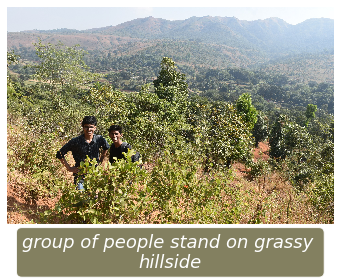


Input   : image_sample.JPG
Caption : group of people stand on grassy hillside


In [119]:
img = feature_extractor(image_name, model_popped)
pred_caption = pred_caption_greedy(img, use_model, max_length, word_to_int, int_to_word)
draw(image_name, pred_caption)
print("\nInput   :", image_name)
print("Caption :", pred_caption)